Author: Sanjeev Dahal <br>
Script for creating limedFBA model of iSD1509, and simulating on different oxygen availability and pyocyanin production rates

### import all packages

In [1]:
#cobra package
import cobra
from cobra import Model, Reaction, Metabolite


#other packages
import os
from os.path import join
import pandas as pd
import numpy as np
import re

#for plotting
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mydir = os.getcwd() #set the directory to the current one

In [3]:
#loading the model
model_iSD = cobra.io.read_sbml_model(join(mydir, 'iSDModel.xml'))

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-08


https://doi.org/10.1101/2021.03.10.434463 does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id


### creating limedFBA model

In [4]:
# convert all to irreversible
for reactions in model_iSD.reactions:
    newcoeff = {}
    if reactions.lower_bound < 0. and reactions.upper_bound > 0.:
        if reactions.id.startswith('EX_'):
            pass
        else:
            reactions.bounds = 0., 1000.

            rxnid = reactions.id + "_irrev2"
            newRxn = Reaction(id = rxnid)
            model_iSD.add_reactions([newRxn])

            for mets in reactions.metabolites:
                newcoeff[mets.id] = -1.*reactions.get_coefficient(mets.id)

            newRxn.add_metabolites(newcoeff)
            
            


#get the metabolites that are constituents of biomass
biomassmets = [k.id for k in model_iSD.reactions.BIOMASS_PA14_v27M.metabolites]


epsii_met_dict = {} #get the epsilon(e) value for each metabolite


for reactions in model_iSD.reactions:    
    for mets in reactions.metabolites:
        sum_binsto = 0. #sum of the binary stoichiometry of the metabolite
        rxn = [] #reactions for the specific metabolite
        for met_rs in model_iSD.metabolites.get_by_id(mets.id).reactions:
            reactant = [r.id for r in met_rs.reactants]
            product = [r.id for r in met_rs.products]
            
            if len(reactant) == 1 and len(product) == 1 and reactant[0][:-2] == product[0][:-2]:
                sum_binsto += 0 #if simple transport, then Sbinary = 0 for that specific metabolite for that reaction.
            else:
                sum_binsto += 1
                rxn.append(met_rs.id)

        
        if sum_binsto == 0:
            epsii_met = 0.1
        else:
            epsii_met = 0.1/(1000.*sum_binsto)
            
        if mets.id in epsii_met_dict.keys():
            pass
        else:
            epsii_met_dict[mets.id] = epsii_met

In [5]:
#(S-e*Sbinary)
for reactions in model_iSD.reactions:
    met2newcoeff = {}
    if 'pyo_c' in [x.id for x in reactions.metabolites]:
        if 'pyo_e' in [x.id for x in reactions.metabolites]: #for transport, binary coeff is 0
            binarycoeff = 0.
            newcoeff = coeff - epsii_met_dict[mets.id] * binarycoeff
        else:
            newreaction = reactions.copy()

            reactions.reaction = '-->'
            for mets in newreaction.metabolites:
                coeff = newreaction.get_coefficient(mets)
                binarycoeff = 1.
                if mets.id in biomassmets: #if in biomass, then e = 0
                    newcoeff = coeff - 0. * binarycoeff
                else:
                    newcoeff = coeff - epsii_met_dict[mets.id] * binarycoeff 

                met2newcoeff[mets] = newcoeff

            reactions.add_metabolites(met2newcoeff)
        
        print(reactions)

rxn11546: gly_c + 2.0000125 pyo_c --> 0.99999918699187 co2_c + 0.9999666666666667 cyan_c + 1.9999833333333332 pyoh2_c
rxn13896: 1.0000166666666668 5mpca_c + 1.0000006451612904 nadh_c + 1.0000013157894736 o2_c --> 0.99999918699187 co2_c + h2o_c + 0.9999993788819875 nad_c + 0.9999875 pyo_c
AKGDHPYO: 1.0000021276595745 akg_c + coa_c + h_c + 1.0000125 pyo_c --> 0.99999918699187 co2_c + 0.9999833333333333 pyoh2_c + 0.9999928571428571 succoa_c
PDHPYO: coa_c + h_c + 1.0000125 pyo_c + 1.0000021276595745 pyr_c --> 0.9999978723404256 accoa_c + 0.99999918699187 co2_c + 0.9999833333333333 pyoh2_c
PYOtex: pyo_e --> pyo_c
NADHPYO: h_c + 1.0000006451612904 nadh_c + 1.0000125 pyo_c --> 0.9999993788819875 nad_c + 0.9999833333333333 pyoh2_c
NADPHPYO: h_c + 1.0000006944444444 nadph_c + 1.0000125 pyo_c --> 0.9999993103448276 nadp_c + 0.9999833333333333 pyoh2_c
rxn11546_irrev2: 1.0000008130081302 co2_c + 1.0000333333333333 cyan_c + 2.0000166666666668 pyoh2_c --> gly_c + 1.9999875 pyo_c
rxn13896_irrev2: 1.0

### previous steps convert iSD1507 to iSD1507_limed for pyocyanin-based reactions

In [6]:
# storing default boundaries for the model
original_bounds_dict = {}
for r in model_iSD.reactions:
    lb, ub = model_iSD.reactions.get_by_id(r.id).lower_bound, model_iSD.reactions.get_by_id(r.id).upper_bound
    original_bounds_dict[r.id] = [lb, ub]

In [7]:
lb_media = pd.read_excel(join(mydir, 'media_LB_SCFM_MM.xlsx'), sheet_name= 'LB', header=0)

medium = {}
for met in lb_media.metabolites:
    metrxn = "EX_" + met + "_e"
    medium[metrxn] = abs(np.float(lb_media[lb_media.loc[:,'metabolites'] == met].lb.values[0]))

    
#check whether growth of iSD1507_limed in LB media is same as iSD1507
with model_iSD:
    for k in model_iSD.reactions:
        k.bounds = original_bounds_dict[k.id][0], original_bounds_dict[k.id][1]
    #check whether growth in LB media is same as iSD1507
    model_iSD.medium = medium

    objective = 'BIOMASS_PA14_v27M'
    model_iSD.reactions.get_by_id(objective).bounds = 0., 1000.
    model_iSD.objective = objective

    print(model_iSD.slim_optimize())

/Users/sanjeevdahal/opt/miniconda3/envs/myCobra/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


1.5323746804956224


### find the highest pyocyanin production rate first for iSD1507_limed

In [8]:
with model_iSD:
    #reset the flux bounds
    for k in model_iSD.reactions:
        k.bounds = original_bounds_dict[k.id][0], original_bounds_dict[k.id][1]
    #set the medium
    model_iSD.medium = medium
    
    #set the objective
    objective = 'BIOMASS_PA14_v27M'
    model_iSD.reactions.get_by_id(objective).bounds = 0., 1000.
    model_iSD.objective = objective
    
    #set the oxygen flux to 0.5
    model_iSD.reactions.O2tex.bounds = 0.5, 0.5
    
    #simulate
    solution_phz_growth = model_iSD.optimize()
    
    #store the pyocyanin production flux to a variable
    max_pyo_syn_flux_limed = solution_phz_growth['rxn13896']
    
print(max_pyo_syn_flux_limed)

0.0008818086649726025


In [9]:
o2_pyo_gr = {} #dictionary to store the data for oxygen availability, pyocyanin production and growth rates

with model_iSD:
    #O2tex flux ranges
    for o2flux in np.arange(0.5, 10.5, 0.5):
        pyo_gr = {} #dictionary to store the data for pyocyanin production and growth rates
        
        #pyocyanin production flux ranges
        for pyo_flux in np.arange(0., (max_pyo_syn_flux_limed + max_pyo_syn_flux_limed/10.), max_pyo_syn_flux_limed/10.):
            #reset the flux bounds
            for r in model_iSD.reactions:
                r.bounds = original_bounds_dict[r.id][0], original_bounds_dict[r.id][1]

            #set the medium
            model_iSD.medium = medium

            #set the objective
            objective = 'BIOMASS_PA14_v27M'
            model_iSD.reactions.get_by_id(objective).bounds = 0., 1000.
            model_iSD.objective = objective
    
            #set the oxygen uptake rate and pyocyanin production rate
            model_iSD.reactions.O2tex.bounds = o2flux, o2flux
            model_iSD.reactions.rxn13896.bounds = pyo_flux, pyo_flux
            
            #simulate
            solution = model_iSD.optimize()
            
            #storing in the dictionary pyo_gr
            if solution.status == 'optimal':
                pyo_gr[solution['rxn13896']] = solution.objective_value
            else:
                pyo_gr[solution['rxn13896']] = 0.
        
        #store the oxygen-pyocyanin-growth in o2_pyo_gr dictionary
        o2_pyo_gr[solution['O2tex']] = pyo_gr

In [10]:
#convert o2_pyo_gr dictionary to a dataframe for easier plotting
df_solution_o2_gr_pyo = pd.DataFrame.from_records(o2_pyo_gr)

#sort the data and then normalize by maximum pyocyanin flux
df_solution_o2_gr_pyo = df_solution_o2_gr_pyo.round(2)
df_solution_o2_gr_pyo = df_solution_o2_gr_pyo.sort_index(ascending=False)
df_solution_o2_gr_pyo.index = df_solution_o2_gr_pyo.index/max_pyo_syn_flux_limed
df_solution_o2_gr_pyo.index = np.round(df_solution_o2_gr_pyo.index, 2)

<IPython.core.display.Javascript object>


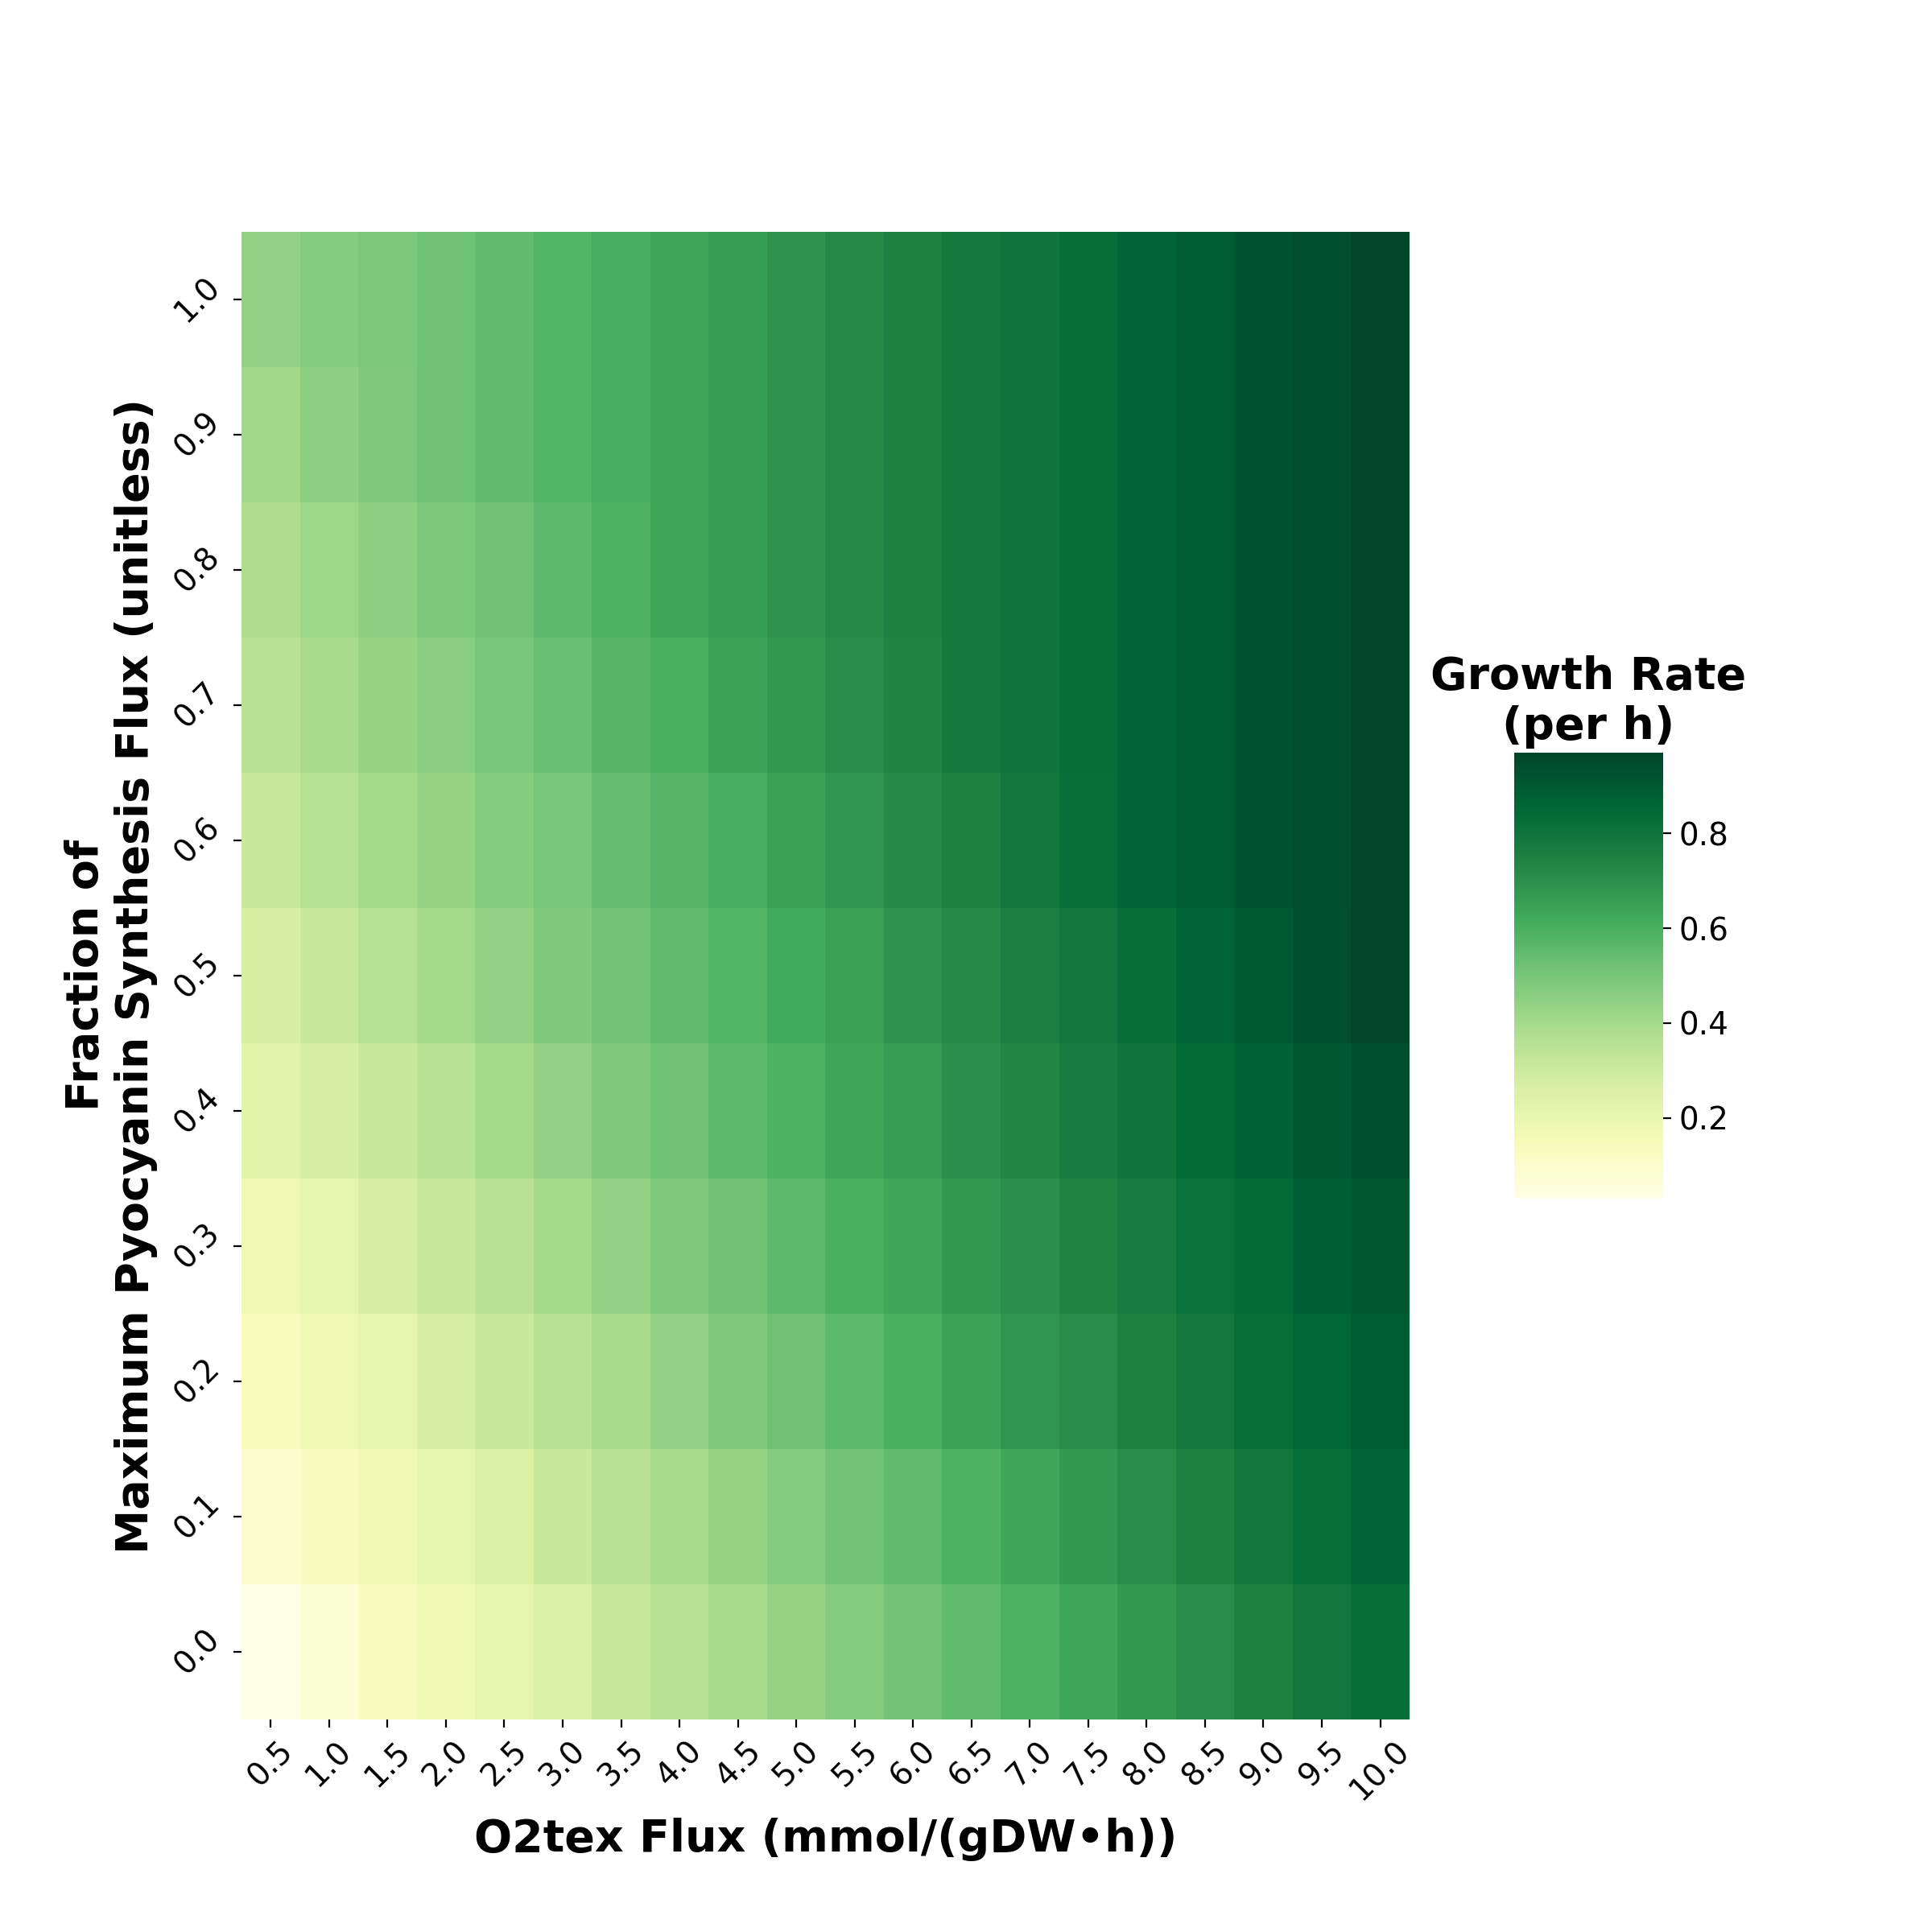

In [11]:
#2d heatmap

# plotting
%matplotlib notebook

fig, ax1 = plt.subplots(1, 1, figsize=[12, 12])



ax1 = sns.heatmap(df_solution_o2_gr_pyo, cmap=cm.YlGn, cbar=True, cbar_kws={"shrink": 0.3, "aspect":3, "pad":0.07})


#setting labels
ax1.set_xlabel("O2tex Flux (mmol/(gDW•h))", fontdict={'weight':'bold', 'size':20}, labelpad=5, rotation=0)
ax1.set_ylabel("Fraction of\nMaximum Pyocyanin Synthesis Flux (unitless)", fontdict={'weight':'bold', 'size':20}, labelpad=5, rotation=90)

#colorbar
colorbar = ax1.collections[0].colorbar
colorbar.ax.set_title(label='Growth Rate\n(per h)', fontdict={'weight':'bold', 'size':20})
colorbar.ax.tick_params(axis='y', labelsize=14)

## rotate the ticks
plt.yticks(rotation=45)
plt.xticks(rotation=45)

plt.tick_params(axis='both', labelsize=14)

plt.show()

